In [104]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

py_file_location = "/content/drive/Shareddrives/STUDENT-capstone-wi23/teamhranalytics/utilities/adspy_shared_utilities.py"
sys.path.append(os.path.abspath(py_file_location))
%cd /content/drive/Shareddrives/STUDENT-capstone-wi23/teamhranalytics/utilities/

random_state = 42

/content/drive/Shareddrives/STUDENT-capstone-wi23/teamhranalytics/utilities


In [32]:
ibm_data = pd.read_csv('/content/drive/Shareddrives/STUDENT-capstone-wi23/teamhranalytics/data/wa_fn-usec_-hr-employee-attrition.csv')

In [3]:
ibm_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# EDA of IBM Dataset

In [4]:
ibm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [5]:
def catconsep(df):
  # https://www.kaggle.com/code/utkarshgaikwad1994/hr-attrition-utkarsh-gaikwad?scriptVersionId=117850320&cellId=22
    cat, con = [], []
    for i in df.columns:
        if df[i].dtype=='object':
            cat.append(i)
        else:
            con.append(i)
    return cat, con

In [57]:
cat,con = catconsep(ibm_data)

In [7]:
ibm_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0


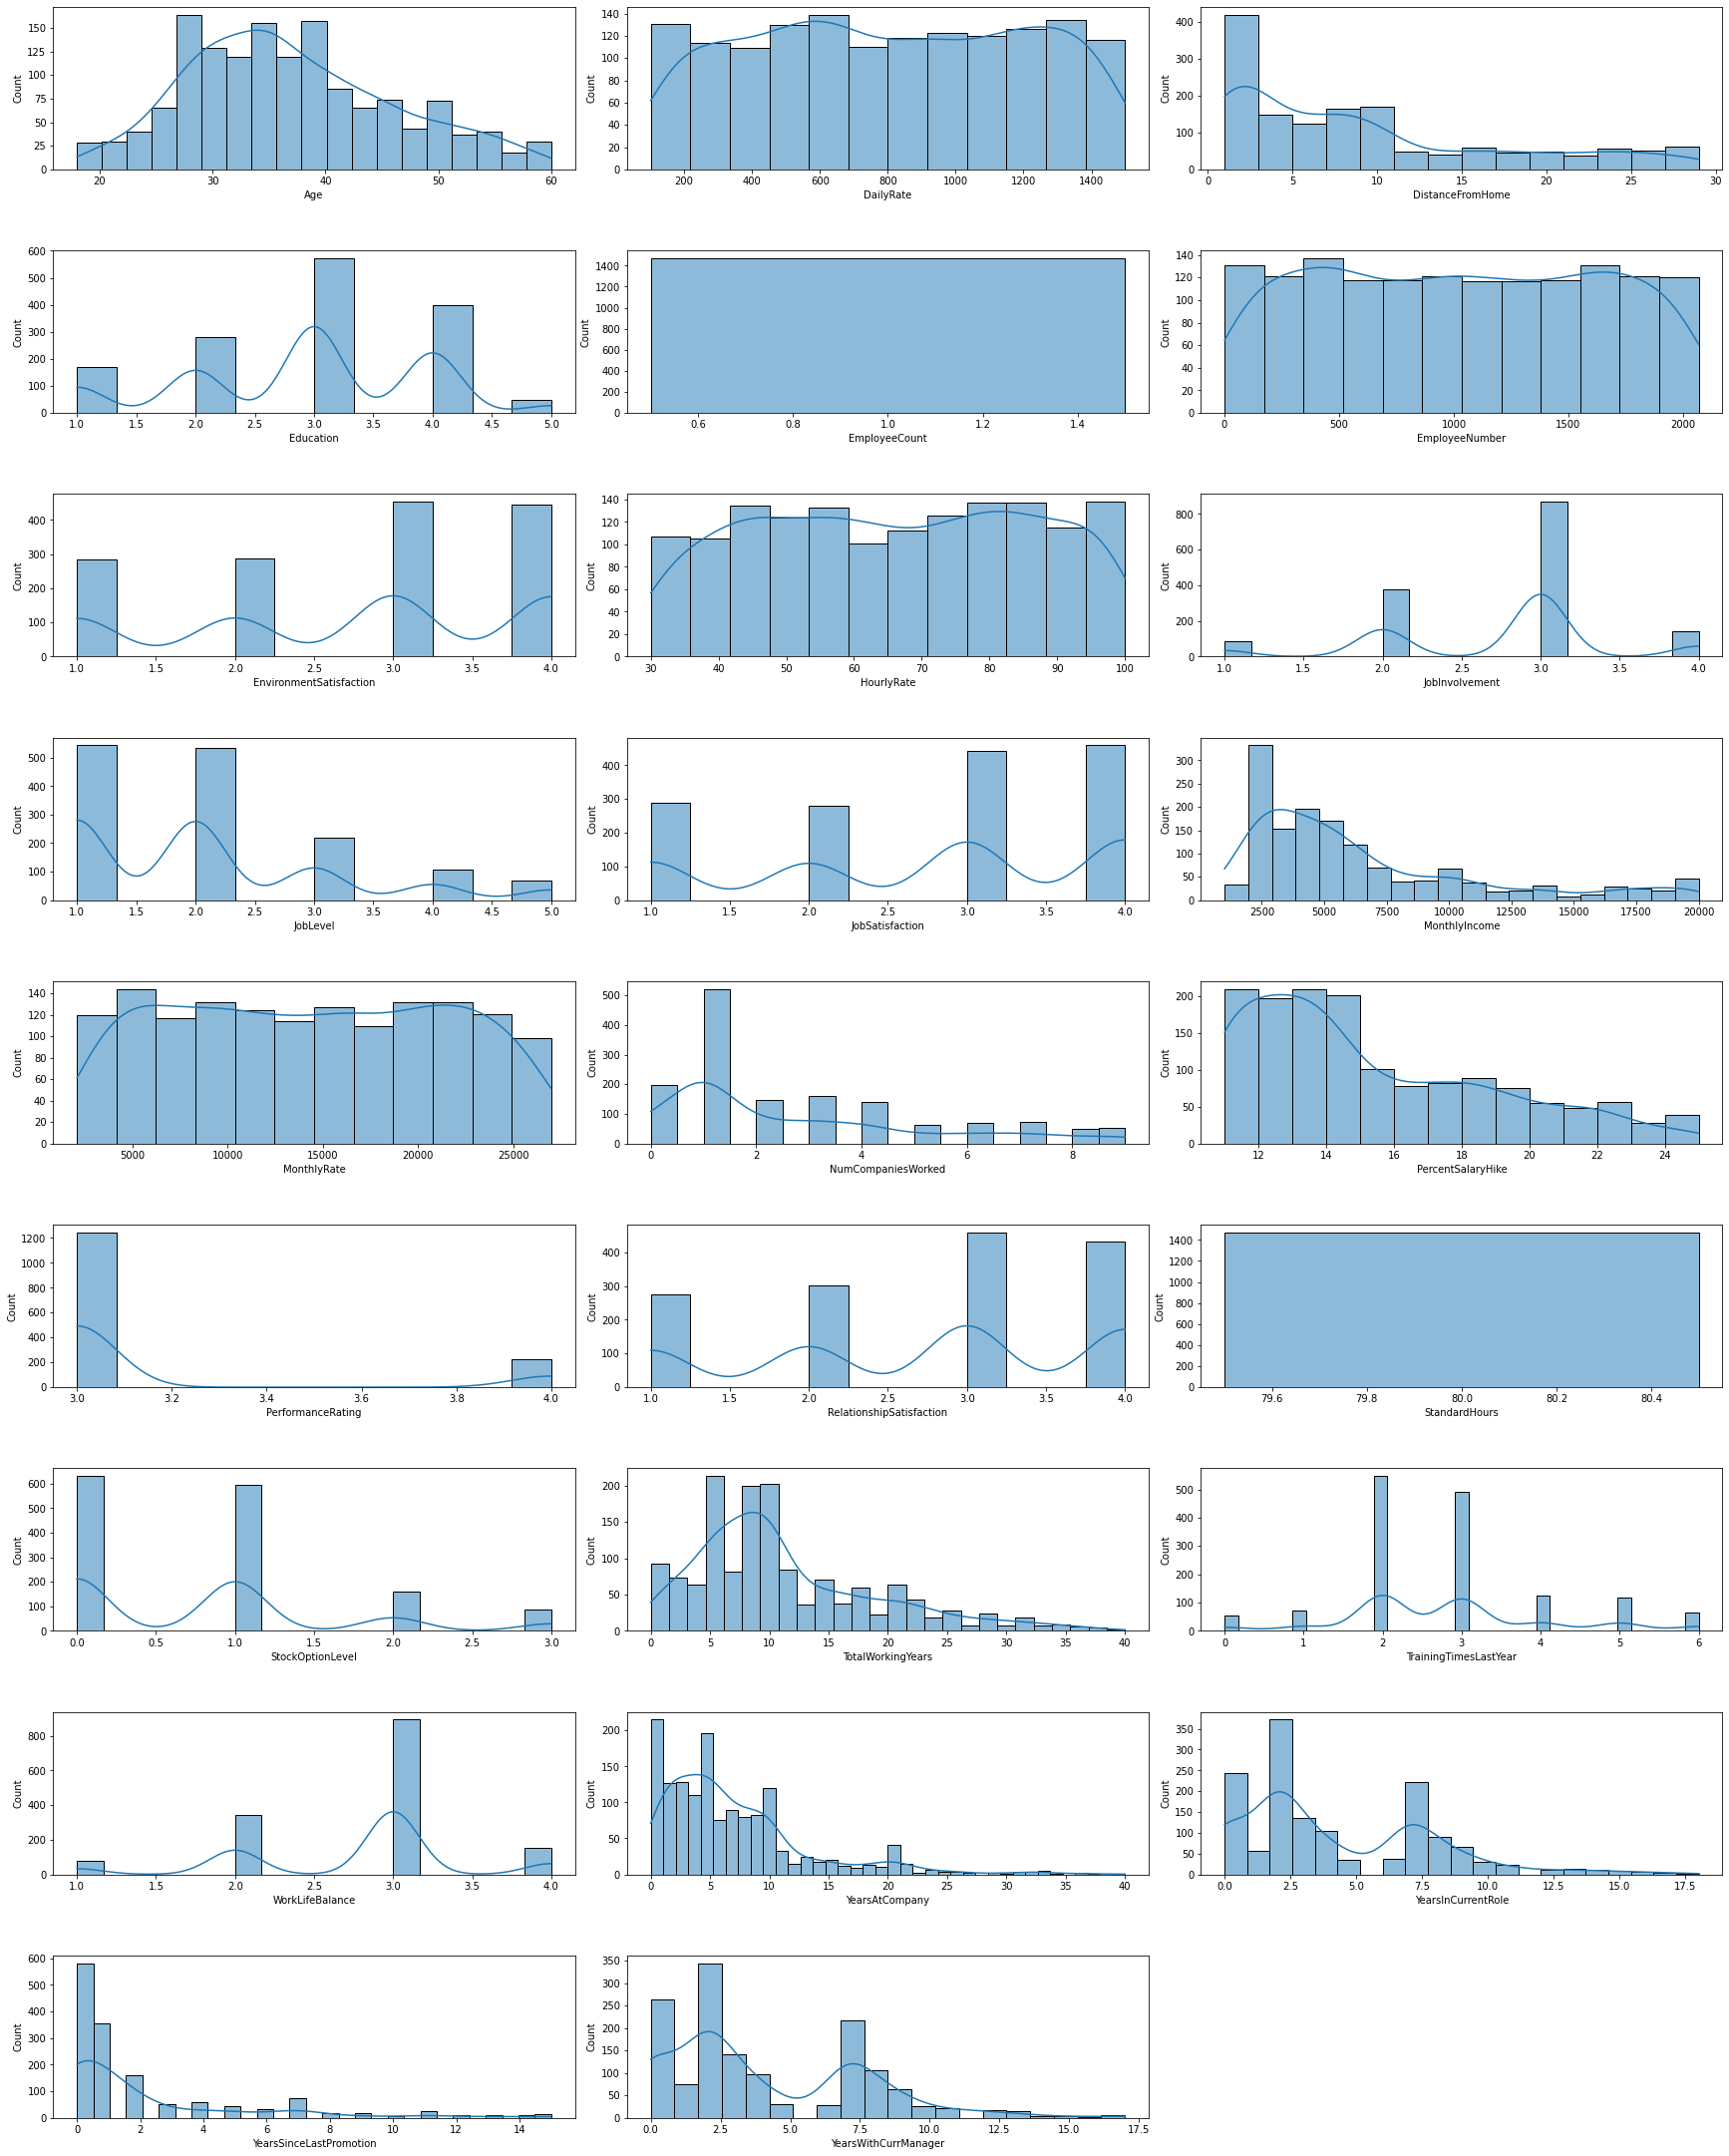

In [8]:
plt.figure(figsize=(30,30))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.1)
x = 1

for i in con:
    plt.subplot(9,3,x)
    x = x+1
    sns.histplot(data = ibm_data, x = i, kde=True)
plt.show()

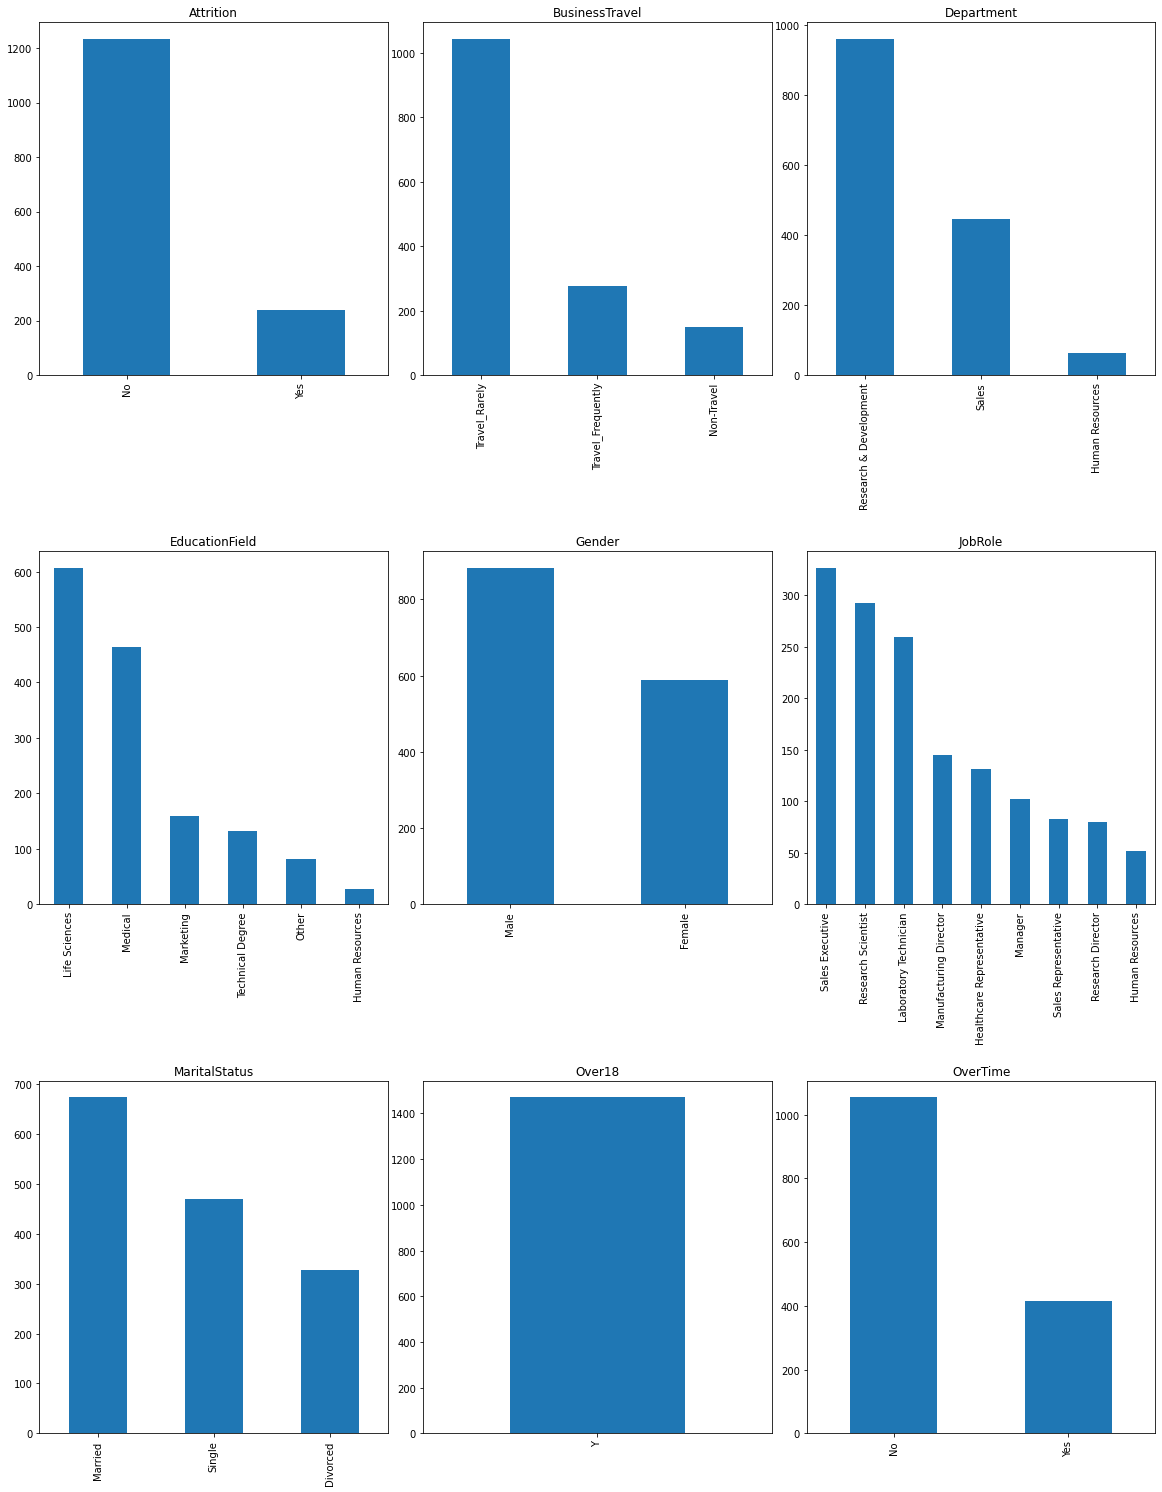

In [9]:
plt.figure(figsize=(20,20))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.1)
for i in cat:
    plt.subplot(3,3,x)
    x = x+1
    ibm_data[i].value_counts().plot(kind='bar')
    plt.title(i)
plt.show()

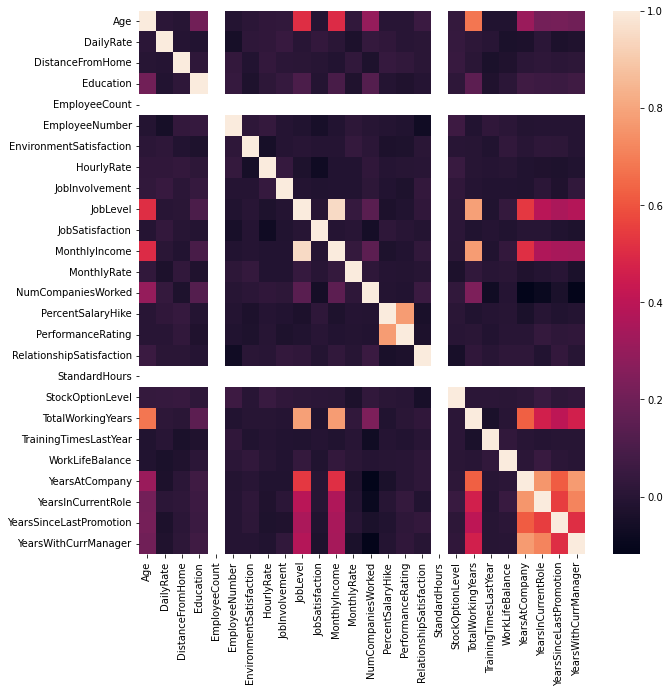

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(ibm_data.corr())
plt.show()

# Decision Tree Classifier

## Preprocessing 

In [61]:
from sklearn.preprocessing import LabelEncoder

df = ibm_data
le = LabelEncoder()
# target variable
y = pd.DataFrame(le.fit_transform(df['Attrition']),columns=df[['Attrition']].columns)

# features encoded
x_cat = pd.get_dummies(df[cat].drop(columns='Attrition'))
x_con = df[con]
X = x_con.join(x_cat)
X = X.drop(columns= ['EmployeeCount', 'EmployeeNumber', 'Over18_Y', 'StandardHours'])

In [63]:
X.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 'Gender_Male', 'JobRole_Healthcare Representative',
       'JobRole_Human Resou

## Train, Validation, Test Sets for Decision Tree

In [64]:
from sklearn.model_selection import train_test_split
# https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c

df = ibm_data
# 80:10:10
train_size=0.8

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
# print(X_valid.shape),print(y_valid.shape)
# print(X_test.shape),print(y_test.shape)

(1176, 51)
(1176, 1)


(None, None)

In [65]:
X_train.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
1090,29,441,8,1,3,39,1,2,1,9715,...,0,0,0,0,0,0,1,0,1,0
826,38,433,1,3,3,37,4,1,3,2844,...,0,0,0,0,0,0,1,0,1,0
665,47,1454,2,4,4,65,2,1,4,3294,...,0,0,0,0,1,0,0,1,0,1
415,34,296,6,2,4,33,1,1,3,2351,...,0,0,0,0,1,1,0,0,1,0
1364,28,783,1,2,3,42,2,2,4,6834,...,0,0,0,1,0,0,1,0,0,1


## Feature Selection


In [35]:
!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Going to conduct various wrapper methods for feature selection on Decision Tree and SVM

# forward selection method
# http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/#sequentialfeatureselector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS 
from sklearn.tree import DecisionTreeClassifier


#Define Sequential Forward Selection (sfs)
sfs = SFS(DecisionTreeClassifier(),
           k_features=(40,54),
          #  forward=True,
           floating=False,
           scoring = 'roc_auc'
           )
#Use SFS to select the top 5 features 
sfs.fit(X_train, y_train)

#Create a dataframe for the SFS results 
df_SFS_results = pd.DataFrame(sfs.subsets_).transpose()
df_SFS_results

## Model Tuning

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

In [68]:
# Decision Tree Grid Search

dt = DecisionTreeClassifier()

#Parameters to run through GridSearch
param_grid = {
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':range(1,10),
    'min_samples_split':range(2,10),
    'min_samples_leaf':range(1,5)
            }

#Run GridSearch
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring = 'roc_auc')
grid_search.fit(X_train, y_train)

#Print out best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 3, 'splitter': 'random'}
Best score:  0.7413683849659266


In [ ]:
import sklearn.metrics
sklearn.metrics.get_scorer_names()

In [89]:
#Best Decision Tree Model used on validation set

dt_final = DecisionTreeClassifier(random_state = random_state,
                                  criterion = 'entropy',
                                  max_depth = 5,
                                  min_samples_leaf = 4,
                                  min_samples_split = 3,
                                  splitter = 'random')

rf_cross_val = cross_validate(dt_final, X_valid, y_valid, cv=5, scoring = ('roc_auc','accuracy','f1'))

#The roc_auc, accuracy, and f-score following 5-fold cross-validation and its standard deviation
print("Mean scores - Decision Tree Best Model; ", 'roc_auc:{:.3f}'.format(np.mean(rf_cross_val['test_roc_auc'])), 'accuracy:{:.3f}'.format(np.mean(rf_cross_val['test_accuracy'])),'f-score:{:.3f}'.format(np.mean(rf_cross_val['test_f1'])))
print("St. Dev. of Scores - Decision Tree Best Model: ",   'roc_auc:{:.3f}'.format(np.std(rf_cross_val['test_roc_auc'])), 'accuracy:{:.3f}'.format(np.std(rf_cross_val['test_accuracy'])),'f-score:{:.3f}'.format(np.std(rf_cross_val['test_f1'])))

Mean scores - Decision Tree Best Model;  roc_auc:0.626 accuracy:0.782 f-score:0.264
St. Dev. of Scores - Decision Tree Best Model:  roc_auc:0.130 accuracy:0.048 f-score:0.173


In [88]:
print("Mean scores - Decision Tree Best Model; ", 'roc_auc:{:.3f}'.format(np.mean(rf_cross_val['test_roc_auc'])), 'accuracy:{:.3f}'.format(np.mean(rf_cross_val['test_accuracy'])),'f-score:{:.3f}'.format(np.mean(rf_cross_val['test_f1'])))
print("St. Dev. of Scores - Decision Tree Best Model: ",   'roc_auc:{:.3f}'.format(np.std(rf_cross_val['test_roc_auc'])), 'accuracy:{:.3f}'.format(np.std(rf_cross_val['test_accuracy'])),'f-score:{:.3f}'.format(np.std(rf_cross_val['test_f1'])))

Mean scores - Decision Tree Best Model;  roc_auc:0.729 accuracy:0.844 f-score:0.290
St. Dev. of Scores - Decision Tree Best Model:  roc_auc:0.022 accuracy:0.012 f-score:0.062


In [94]:
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

features = list(X_valid.columns)
# features.remove("Attrition")

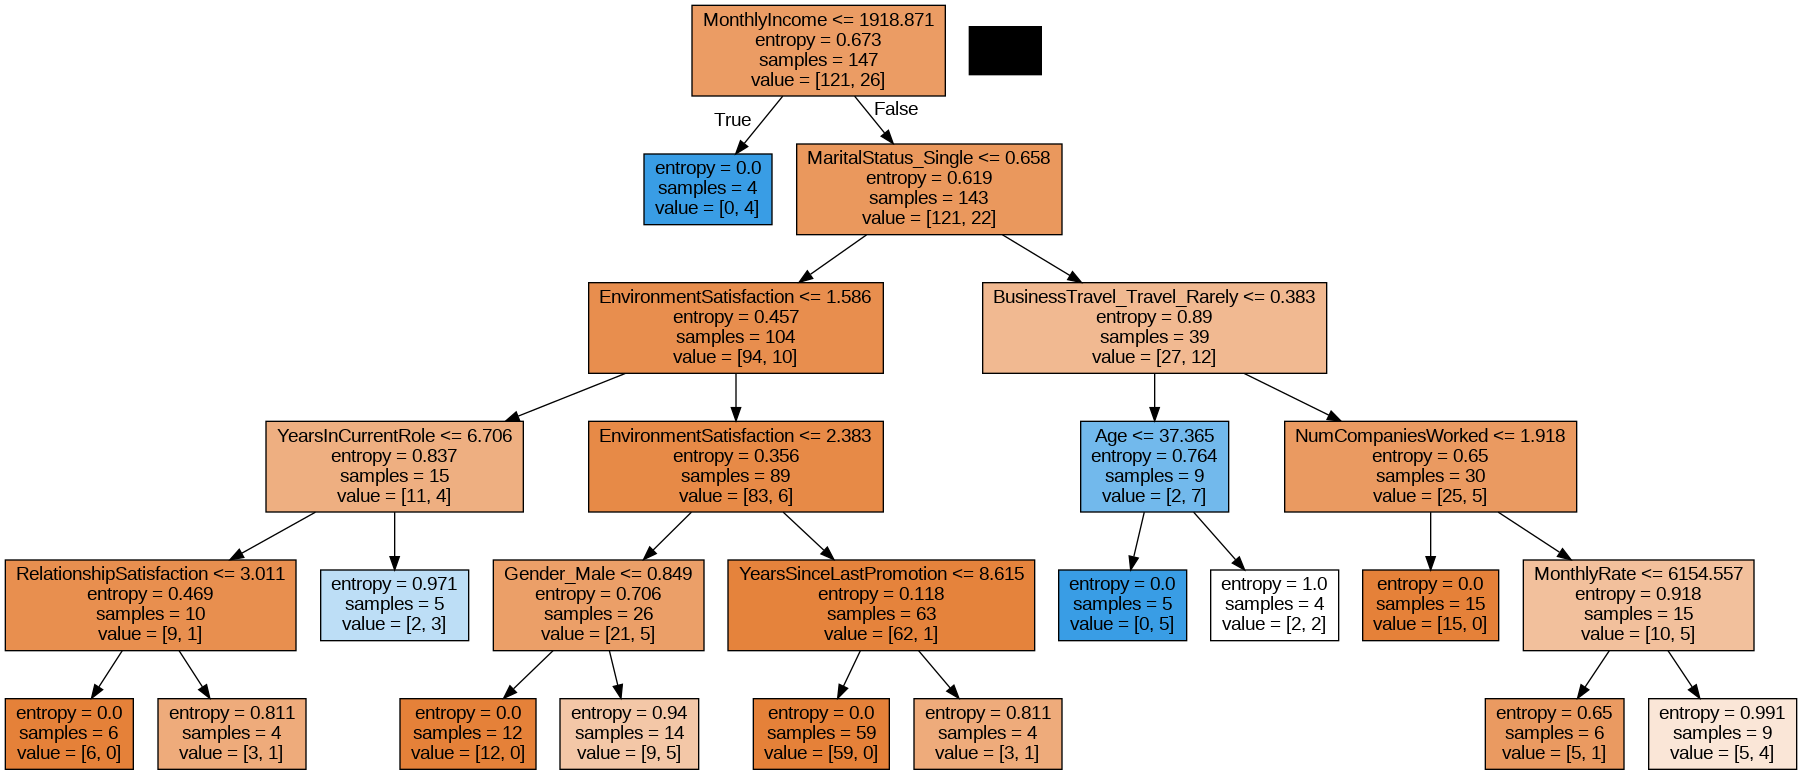

In [95]:
dt_final.fit(X_valid, y_valid)
dot_data = StringIO()
export_graphviz(dt_final, out_file=dot_data, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

In [106]:
from adspy_shared_utilities import plot_decision_tree

In [110]:
target_values = ['0','1']

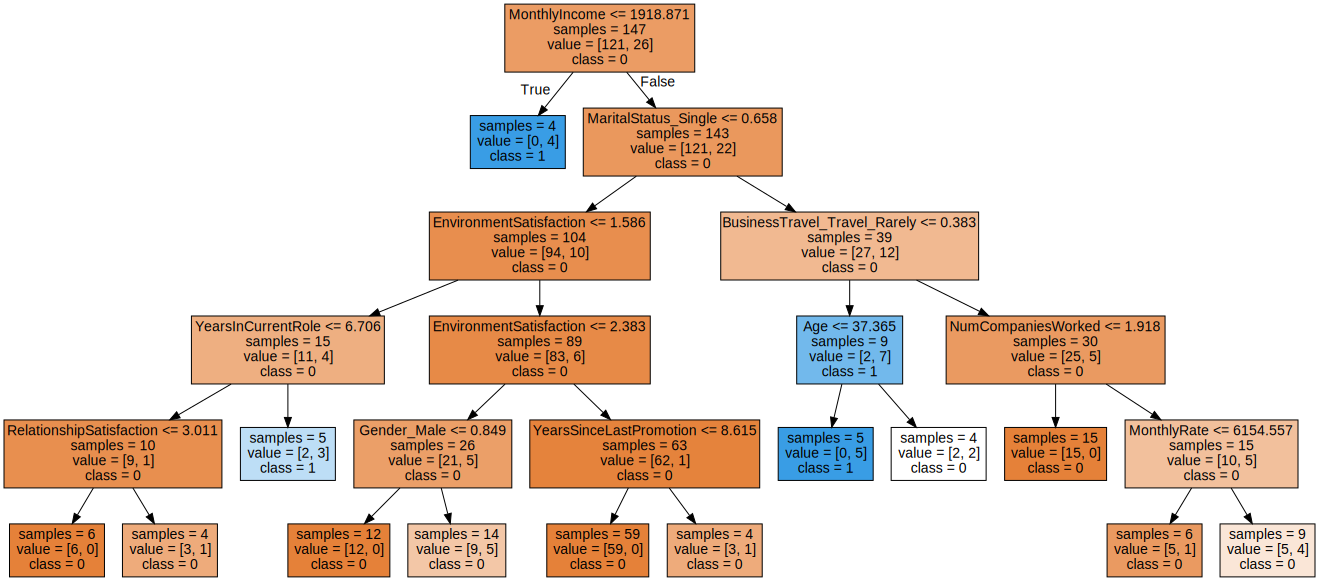

In [111]:
plot_decision_tree(dt_final, features, target_values)

## SHAP Score for DT

# SVM Classifier

In [20]:
from sklearn import svm

svm = svm.SVC()



#Parameters to run through GridSearch
param_grid = {
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':range(1,10),
    'min_samples_split':range(1,10),
    'min_samples_leaf':range(1,5)
            }

#Run GridSearch
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring = 'roc_auc')
grid_search.fit(X_train, y_train)

#Print out best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Streaming output truncated to the last 5000 lines.
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when 

KeyError: ignored